# Groundwater levels

In this script we analyse the groundwater table levels, as they were collected by the piezometers in Alpnachstad. 

In [1]:
#test_flag_colab
from google.colab import drive
drive.mount('/content/drive')

# working directory: drive/MyDrive/spundsteif
%cd '/content/drive/MyDrive/spundsteif'

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/spundsteif


# Import the libraries

In [2]:
import pandas as pd
import numpy as np
import io
import csv
from datetime import datetime, date, timedelta

from google.colab import files

from copy import copy

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn import linear_model

import re

# Import the data

## Read the piezometer data

In [3]:
PIEZOMETER_AUTOMATIC = './data/rawdata_Piezo_automatisch.csv'
df_piezo = pd.read_csv(PIEZOMETER_AUTOMATIC, delimiter=',')

# covert the column 'Aufnahmezeit' into python datetime objects and sort in chronological order
for index, row in df_piezo.iterrows():
  df_piezo.at[index, 'Aufnahmezeit'] = datetime.strptime(df_piezo.at[index, 'Aufnahmezeit'], '%Y-%m-%d  %H:%M:%S')

df_piezo = df_piezo.sort_values('Aufnahmezeit', ascending=True)

df_piezo = df_piezo.drop(columns='Unnamed: 0', axis=1)
df_piezo.set_index('Aufnahmezeit', inplace=True)

df_piezo

,Tiefe_GW,Temperatur_GW
Aufnahmezeit,,
2021-09-22 09:55:00,2.09,13.8
2021-09-22 10:00:00,2.09,13.5
2021-09-22 10:05:00,2.09,13.5
2021-09-22 10:10:00,2.09,13.4
2021-09-22 10:15:00,2.09,13.4
...,...,...
2022-04-11 06:00:00,1.74,11.2
2022-04-11 12:00:00,1.28,11.2
2022-04-11 18:00:00,1.23,11.2


In [4]:
# No data was recorded between the 3rd and the 24th of February 2022.

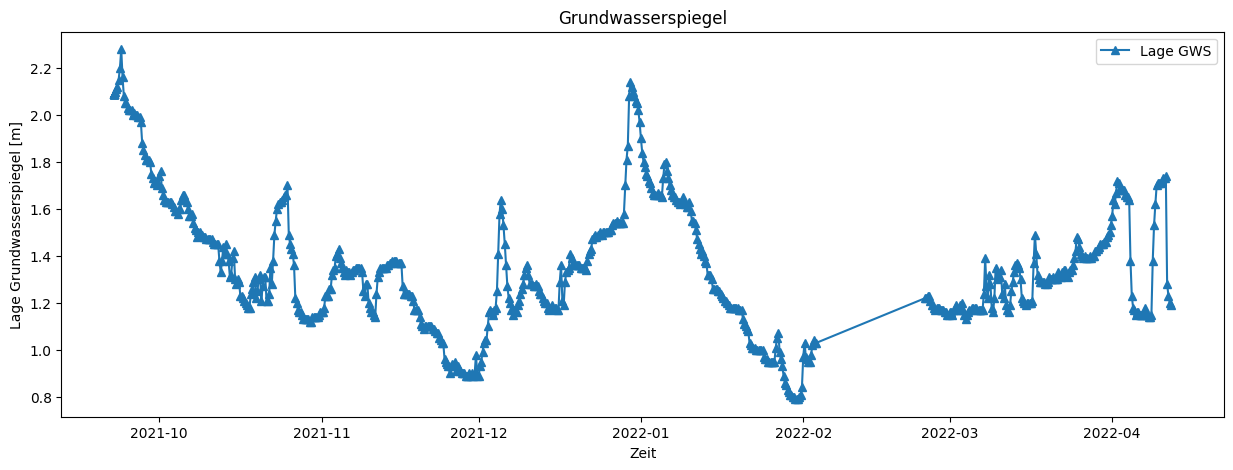

In [5]:
# plot depth of groundwater table

plt.figure(figsize=(15,5))
plt.title('Grundwasserspiegel')
plt.plot(df_piezo.Tiefe_GW, marker='^', linestyle='-', label='Lage GWS')
plt.xlabel('Zeit')
plt.ylabel('Lage Grundwasserspiegel [m]')
plt.legend()
plt.show()

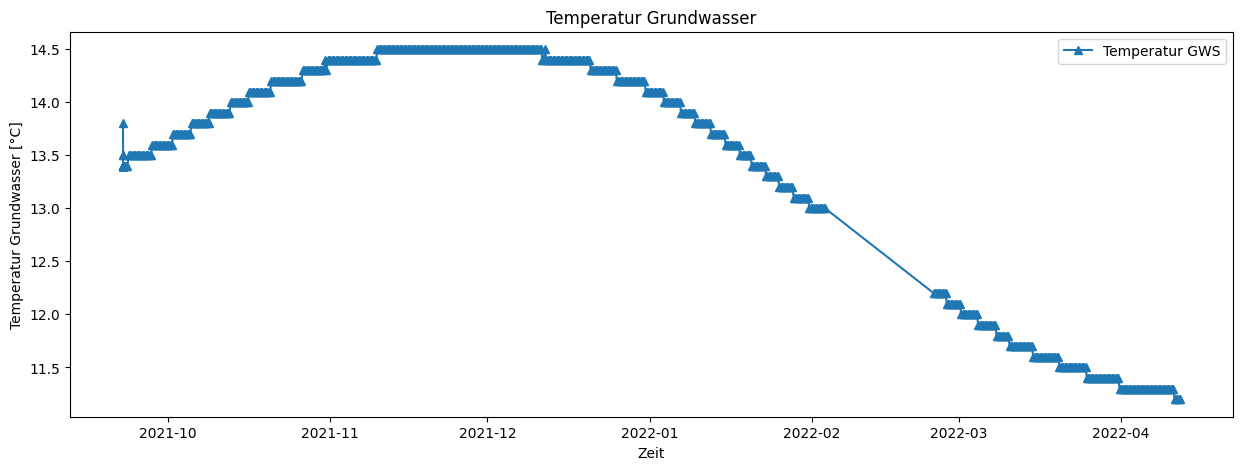

In [6]:
# plot groundwater temperature

plt.figure(figsize=(15,5))
plt.title('Temperatur Grundwasser')
plt.plot(df_piezo.Temperatur_GW, marker='^', linestyle='-', label='Temperatur GWS')
plt.xlabel('Zeit')
plt.ylabel('Temperatur Grundwasser [°C]')
plt.legend()
plt.show()

## Read the groundwater table data (piezometer nr. 6)

In [7]:
PIEZO6_FILE_NAME = './data/rawdata_Piezo_nr_6.csv'
df_piezo6 = pd.read_csv(PIEZO6_FILE_NAME, delimiter=';')

# covert the column 'DateTime' into python datetime objects and sort them in chronological order: 
for index, row in df_piezo6.iterrows():
    df_piezo6.at[index, 'DateTime'] = datetime.strptime(df_piezo6.at[index, 'DateTime'], '%d.%m.%Y %H:%M')

df_piezo6 = df_piezo6.sort_values('DateTime', ascending=True)

print(df_piezo6)
print(df_piezo6.columns)

                 DateTime  Piezo6 [Meter ueber Meer]
0     2021-06-23 18:00:00                   435.6137
1     2021-06-23 20:00:00                   435.4870
2     2021-06-23 22:00:00                   435.4493
3     2021-06-24 00:00:00                   435.4176
4     2021-06-24 02:00:00                   435.4033
...                   ...                        ...
9039  2021-11-11 10:45:00                   434.2706
9040  2021-11-11 11:00:00                   434.2788
9041  2021-11-11 11:15:00                   434.2865
9042  2021-11-11 11:30:00                   434.2958
9043  2021-11-11 11:45:00                   434.2971

[9044 rows x 2 columns]
Index(['DateTime', 'Piezo6 [Meter ueber Meer]'], dtype='object')


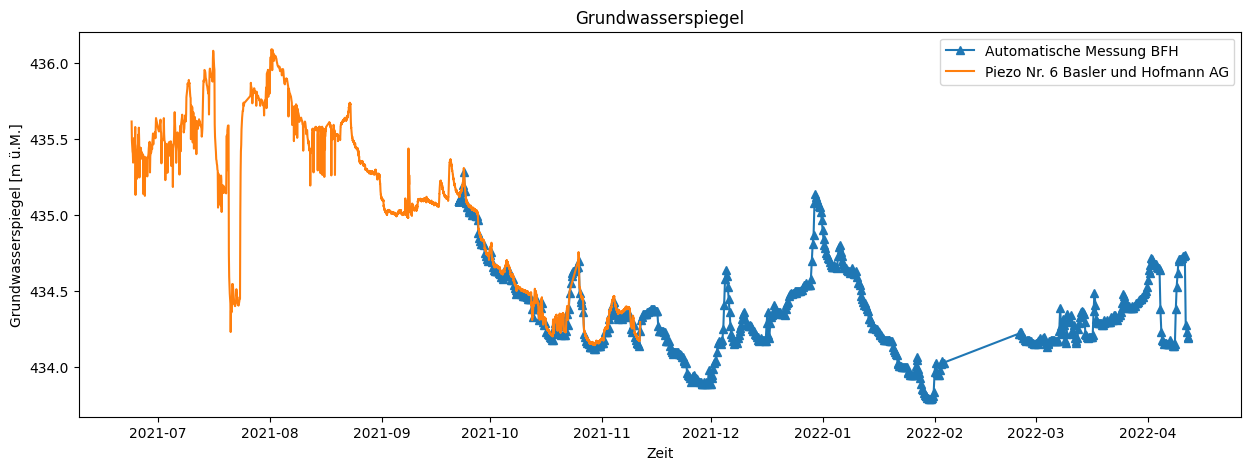

In [8]:
# Compare our measurements with those by Basler und Hofmann AG

df_piezo['new_GSW'] = df_piezo.Tiefe_GW + 433

plt.figure(figsize=(15,5))
plt.title('Grundwasserspiegel')
plt.plot(df_piezo.new_GSW, marker='^', linestyle='-', label='Automatische Messung BFH')
plt.plot(df_piezo6.DateTime, df_piezo6['Piezo6 [Meter ueber Meer]'], marker='', linestyle='-', label='Piezo Nr. 6 Basler und Hofmann AG')
plt.xlabel('Zeit')
plt.ylabel('Grundwasserspiegel [m ü.M.]')
plt.legend()
plt.show()

In [9]:
# let's properly calibrate the offset in the two curves
# mid september to mid november

mid_sept = datetime(2021, 9, 15)
mid_nov = datetime(2021, 11, 15)

# get start index in orange curve
mid_sept_index = df_piezo6.loc[df_piezo6['DateTime'] > mid_sept].index[0]
print(mid_sept_index)

3771


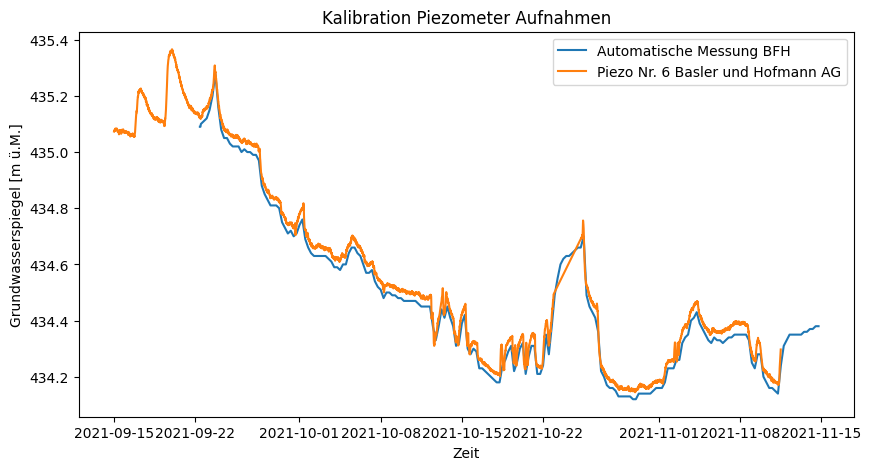

In [10]:
plt.figure(figsize=(10,5))
plt.title('Kalibration Piezometer Aufnahmen')
plt.plot(df_piezo[df_piezo.index < mid_nov]['new_GSW'], marker='', linestyle='-', label='Automatische Messung BFH')
plt.plot(df_piezo6.DateTime[3771:], df_piezo6['Piezo6 [Meter ueber Meer]'][3771:], marker='', linestyle='-', label='Piezo Nr. 6 Basler und Hofmann AG')
plt.xlabel('Zeit')
plt.ylabel('Grundwasserspiegel [m ü.M.]')
plt.legend()
plt.show()
# Abweichung sehr gering, ca. 2 cm --> in Ordnung

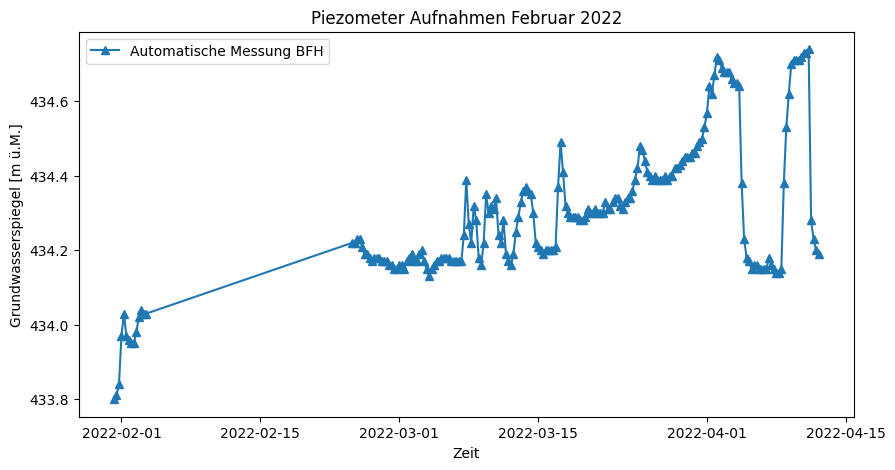

In [12]:
# At which depth does the groundwater table lie during the excavation works in front of the instrumented sheet piles? 

end_jan = datetime(2022, 1, 31)

plt.figure(figsize=(10,5))
plt.title('Piezometer Aufnahmen Februar 2022')
plt.plot(df_piezo[df_piezo.index > end_jan]['new_GSW'], marker='^', linestyle='-', label='Automatische Messung BFH')
plt.xlabel('Zeit')
plt.ylabel('Grundwasserspiegel [m ü.M.]')
plt.legend()
plt.show()

At the beginning of February 2022 the groundwater table is presumably located at ca. 434.0 - 434.5 m above sea level (gap in the data). The groundwater table is needed for the numerical simulations in Plaxis 2D. 